In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import ulmo
import calendar

import pandas as pd
from pandas.io.json import json_normalize

from datetime import timedelta

import json

from matplotlib import lines

import numpy as np

%matplotlib inline

# Study Sites Climatological Comparisons
## Tuolumne

In [2]:
dana_snotel = pd.read_csv("DANA_MEADOWS_1980.txt", parse_dates=[4])
dana_snotel.loc[dana_snotel.VALUE == '---', 'VALUE']= pd.np.nan
dana_snotel.VALUE = pd.to_numeric(dana_snotel.VALUE)

In [3]:
dana_snotel.head()

,STATION_ID,DURATION,SENSOR_NUMBER,SENSOR_TYPE,DATE TIME,OBS DATE,VALUE,DATA_FLAG,UNITS
0,DAN,D,82,SNO ADJ,1980-10-26,19801026 0000,0.0,NaN,INCHES
1,DAN,D,82,SNO ADJ,1980-10-27,19801027 0000,0.7,NaN,INCHES
2,DAN,D,82,SNO ADJ,1980-10-28,19801028 0000,0.7,NaN,INCHES
3,DAN,D,82,SNO ADJ,1980-10-29,19801029 0000,0.7,NaN,INCHES
4,DAN,D,82,SNO ADJ,1980-10-30,19801030 0000,0.7,NaN,INCHES


/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


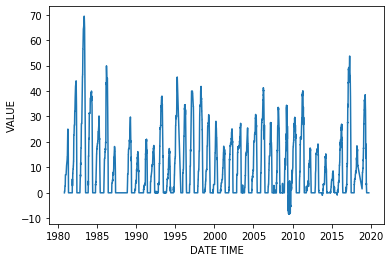

In [4]:
sns.lineplot(x='DATE TIME', y = 'VALUE', data=dana_snotel)

In [5]:
def assign_wy(date):
    if not pd.isna(date):
        if date.month>=10:
            return(pd.datetime(date.year+1,1,1).year)
        else:
            return(pd.datetime(date.year,1,1).year)
    else: 
        return pd.NaT
    


In [6]:
dana_snotel['DATE TIME'].min().year

1980

In [7]:
dana_snotel['WY'] = dana_snotel['DATE TIME'].apply(assign_wy)

In [8]:
dana_snotel.loc[dana_snotel.VALUE > 130, 'VALUE'] = pd.np.nan

In [9]:
dana_snotel = dana_snotel.dropna(axis=0, subset=['VALUE'])

In [10]:
dana_snotel['DATE TIME'].min().year

1980

In [11]:
wyd = dana_snotel.groupby("WY").apply(lambda g: g.reset_index())

In [12]:
dana_snotel['wyd'] = dana_snotel.apply(lambda x: x['DATE TIME'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

In [13]:
def wyd_to_doy(wyd):
    if(wyd > 366): return np.nan
    doy = pd.datetime(1999, 10, 1) + timedelta(days=wyd)
    return"{} {}".format(calendar.month_abbr[doy.month], doy.day)

In [14]:
def format_doy(value, tick_number):
    # find number of multiples of pi/2
    return(wyd_to_doy(value))



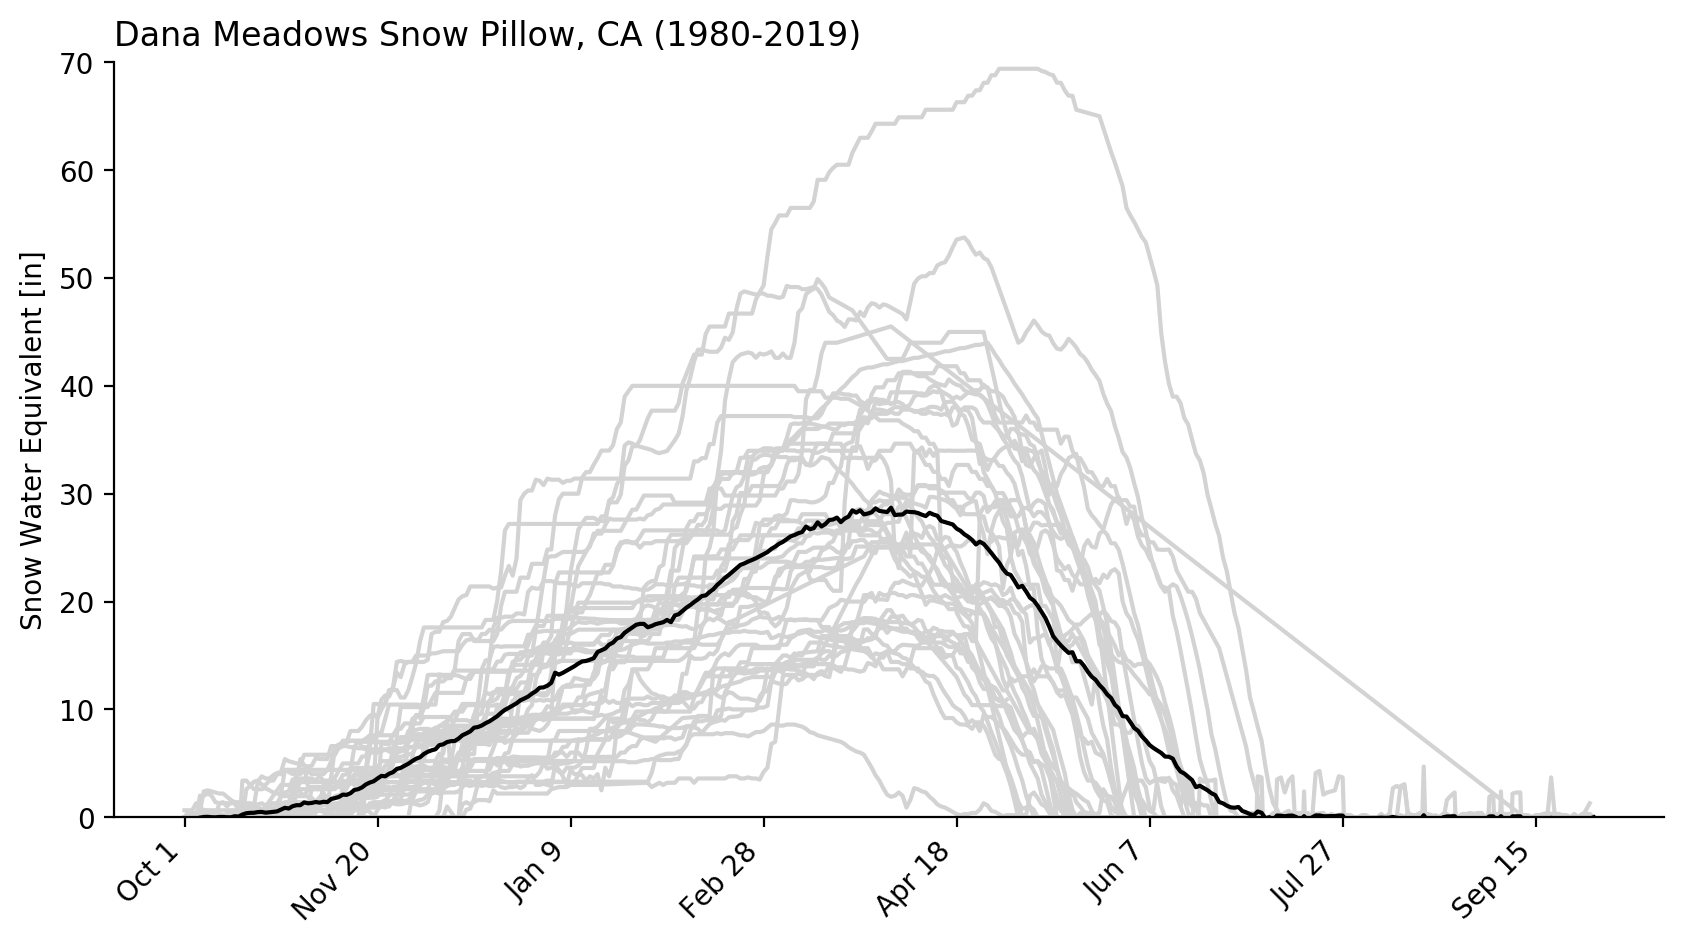

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

for group in dana_snotel.groupby("WY"):
    ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").mean().VALUE.values, color='lightgray')
    
ax.plot(dana_snotel.groupby("wyd").mean().index.days, dana_snotel.groupby("wyd").mean()['VALUE'].values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 70])
ax.set_ylabel("Snow Water Equivalent [in]")
minyear = dana_snotel['DATE TIME'].min().year
maxyear = dana_snotel['DATE TIME'].max().year
ax.set_title("Dana Meadows Snow Pillow, CA ({}-{})".format(minyear, maxyear), loc='left')
sns.despine()

## Colorado

In [16]:
co_snotel = pd.read_csv("SNOTEL669_WTEQ.txt", comment='#', parse_dates=[0])

In [17]:
co_snotel.columns

Index(['Date', 'North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values'], dtype='object')

In [18]:
co_snotel = co_snotel.rename({"North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values" : "WTEQ"}, axis=1)

In [19]:
co_snotel

,Date,WTEQ
0,1985-09-18,0.0
1,1985-09-19,0.0
2,1985-09-20,0.0
3,1985-09-21,0.0
4,1985-09-22,0.0
...,...,...
12581,2020-02-28,14.6
12582,2020-02-29,14.7
12583,2020-03-01,14.7
12584,2020-03-02,15.1


In [20]:
co_snotel['WY'] = co_snotel.Date.apply(assign_wy)

In [21]:
co_snotel['wyd'] = co_snotel.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

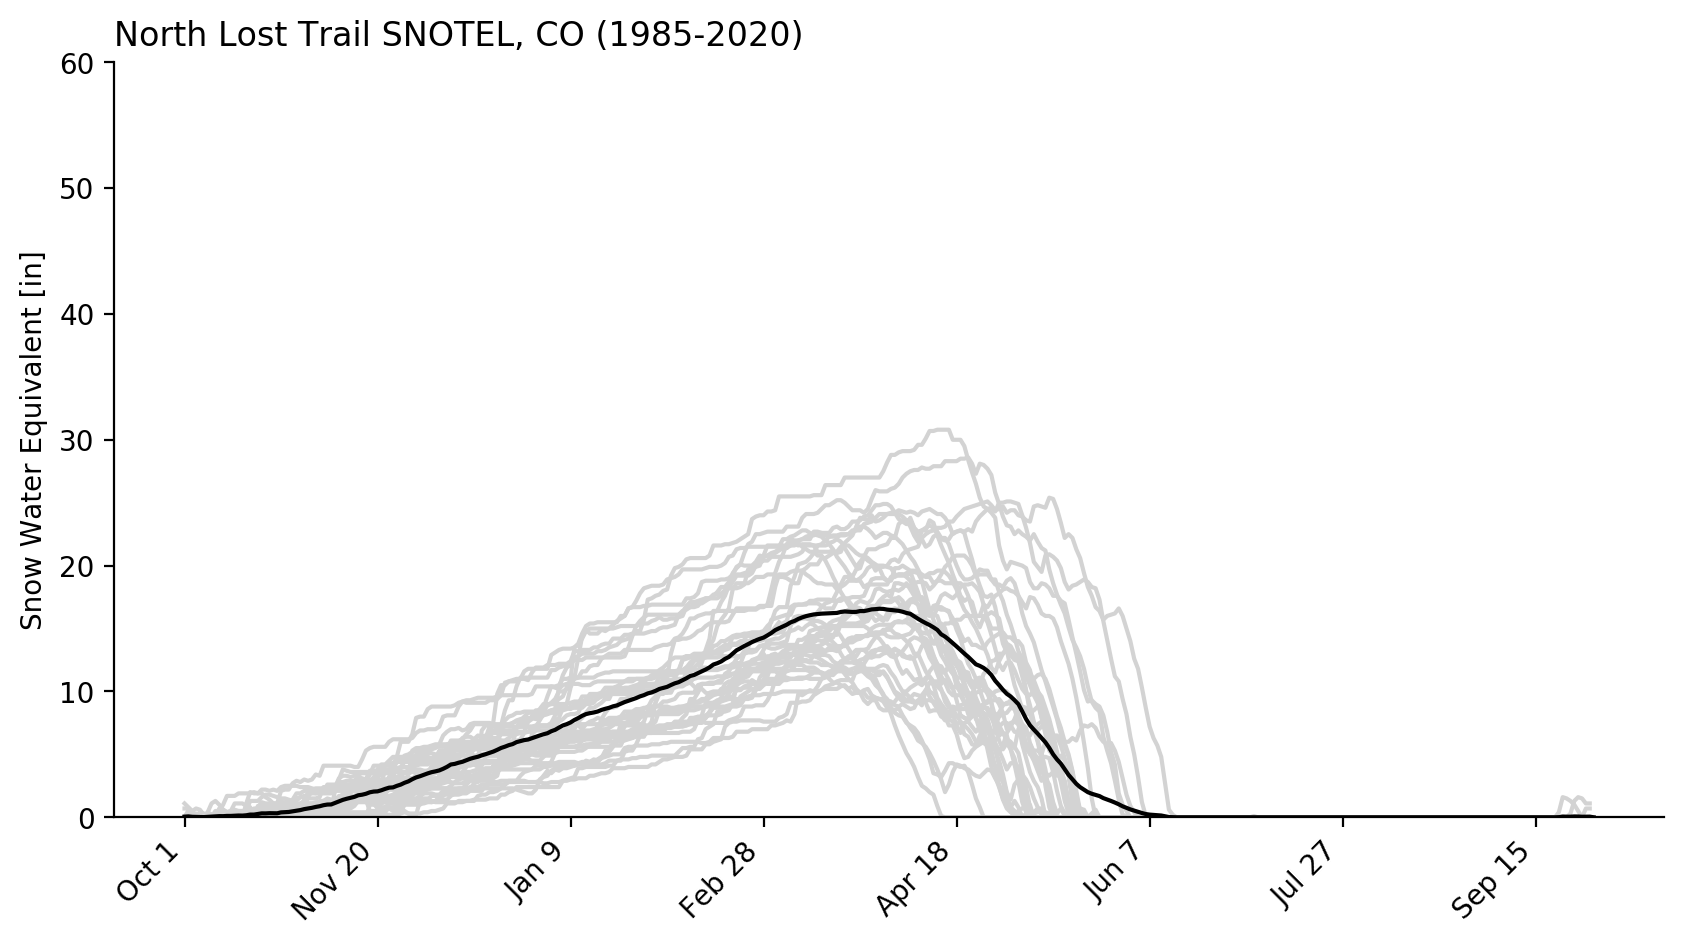

In [22]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
snotel = co_snotel
for group in snotel.groupby("WY"):
    ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").mean().WTEQ.values, color='lightgray')
    
ax.plot(snotel.groupby("wyd").mean().index.days, snotel.groupby("wyd").mean().WTEQ.values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 60])
ax.set_ylabel("Snow Water Equivalent [in]")
ax.set_title("North Lost Trail SNOTEL, CO (1985-2020)", loc='left')
sns.despine()

In [23]:
def plot_snow(data, snowcol, title, ax, sharey=False):
    for group in data.groupby("WY"):
        ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").median()[snowcol].values, color='lightgray')
    
    ax.plot(data.groupby("wyd").mean().index.days, data.groupby("wyd").median()[snowcol].values, color='black')

    locs, labels = plt.xticks()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
#     plt.setp(ax.get_xticklabels(), ha="right", rotation=0)
    ax.set_ylim([0, 70])
    if not sharey:
        ax.set_ylabel("SWE [in]")
    ax.set_title(title, loc='left')
    sns.despine()

## Both

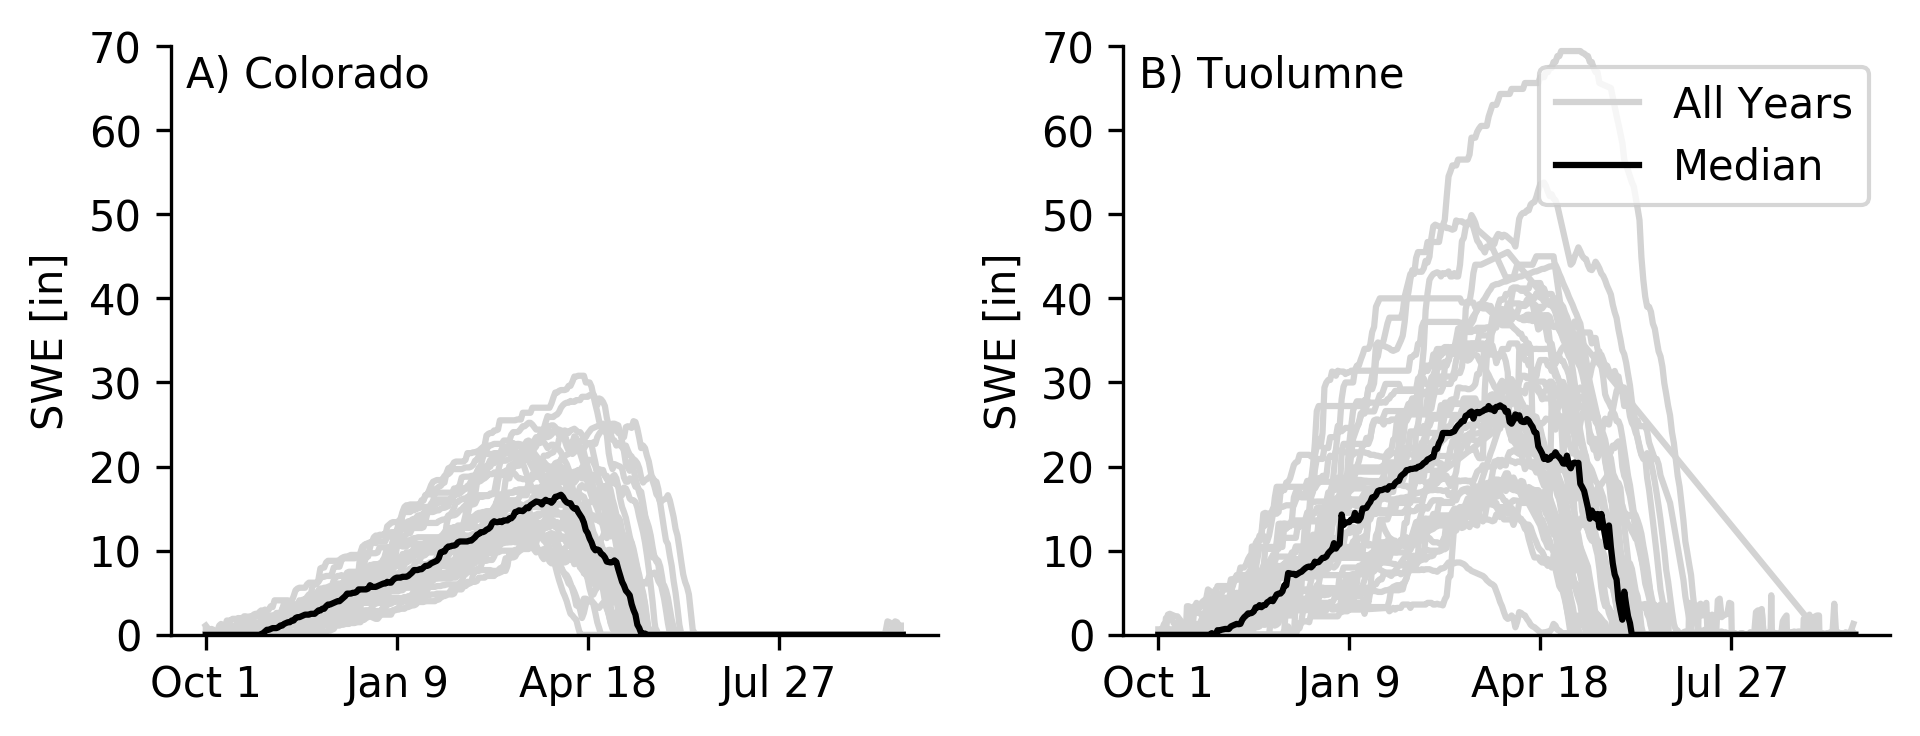

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,2.5), dpi=300)

co_minyear = co_snotel.Date.min().year
co_maxyear = co_snotel.Date.max().year
# title = f"North Lost Trail SNOTEL, CO ({co_minyear}-{co_maxyear})"
title = ""
plot_snow(co_snotel, 'WTEQ', title, axes[0])

dana_minyear = dana_snotel["DATE TIME"].min().year
dana_maxyear = dana_snotel["DATE TIME"].max().year
# title  =f"Dana Meadows Snow Pillow, CA ({dana_minyear}-{dana_maxyear})"
title=""
plot_snow(dana_snotel, "VALUE", title, axes[1])

plt.tight_layout() 

axes[1].legend(handles=[
    lines.Line2D([], [], color='lightgray', label="All Years"),
    lines.Line2D([], [], color='black', label="Median")
], loc='upper right')

axes[0].text(0.02, .93, 'A) Colorado', transform=axes[0].transAxes)
axes[1].text(0.02, .93, 'B) Tuolumne', transform=axes[1].transAxes)
# axes[0].text(0.75, .93, f'{co_minyear}-{co_maxyear}', fontsize=8, color='lightgray', transform=axes[0].transAxes)
# axes[1].text(0.75, .93, f'{dana_minyear}-{dana_maxyear}', fontsize=8, color='lightgray', transform=axes[1].transAxes)


plt.savefig("swe-test.pdf", dpi=300)
plt.savefig("swe-test.png", dpi=300)

## Temp – CA

In [25]:
dana_temp = pd.read_csv("DANA_MEADOWS_1980_AIRAVG.txt", parse_dates=["DATE TIME"])
dana_temp.loc[dana_temp.VALUE == '---', 'VALUE']= pd.np.nan
dana_temp = dana_temp.dropna(axis=0, subset=['VALUE'])
dana_temp.VALUE = pd.to_numeric(dana_temp.VALUE)

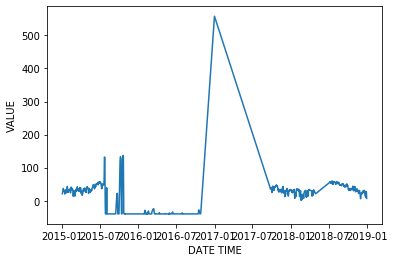

In [26]:
sns.lineplot(x = "DATE TIME", y= 'VALUE', data=dana_temp[dana_temp['DATE TIME'].between('2015-01-01', '2018-12-31')])

In [489]:
dana_temp = dana_temp.drop(dana_temp[dana_temp['DATE TIME'].between('2015-01-01', '2018-12-31')].index)

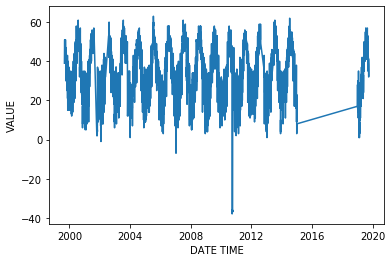

In [490]:
sns.lineplot(x = "DATE TIME", y= 'VALUE', data=dana_temp)

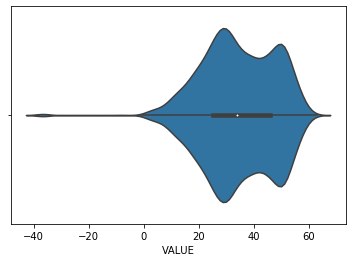

In [516]:
sns.violinplot(dana_temp.VALUE, split='True')

## CO



In [510]:
co_tavg = pd.read_csv("SNOTEL669_TAVG.txt", comment='#', parse_dates=['Date'])
co_tavg = co_tavg.rename({"North Lost Trail (669) Air Temperature Average (degF)": "TAVG"}, axis=1)

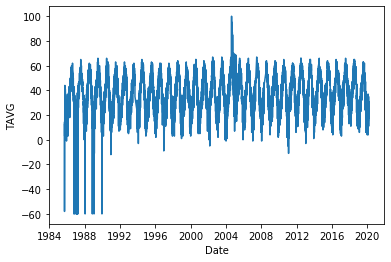

In [512]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

In [514]:
co_tavg.loc[co_tavg.TAVG < -30, 'TAVG'] = pd.np.nan
co_tavg = co_tavg.dropna(subset=["TAVG"])

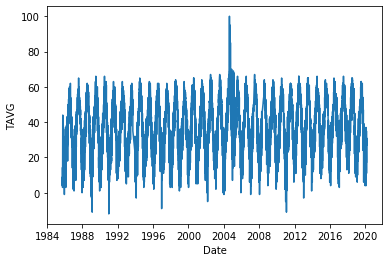

In [515]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

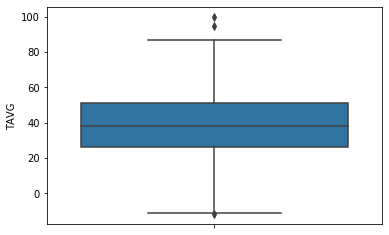

In [521]:
sns.boxplot(y = co_tavg.TAVG)

In [531]:
co_tavg = co_tavg.assign(loc='CO')
ca_tavg = dana_temp.assign(loc='CA')

In [532]:
co_tavg

,Date,TAVG,loc
0,1985-09-18,14.0,CO
1,1985-09-19,11.0,CO
2,1985-09-20,10.0,CO
3,1985-09-21,10.0,CO
5,1985-09-23,4.0,CO
...,...,...,...
12580,2020-02-27,26.0,CO
12581,2020-02-28,28.0,CO
12582,2020-02-29,31.0,CO
12583,2020-03-01,31.0,CO


In [541]:
combined = pd.melt(pd.concat([co_tavg[['loc', 'TAVG']], ca_tavg[['loc','VALUE']]]).rename({"VALUE": "TAVG"}, axis=1), id_vars=['loc'], var_name='TAVG')

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


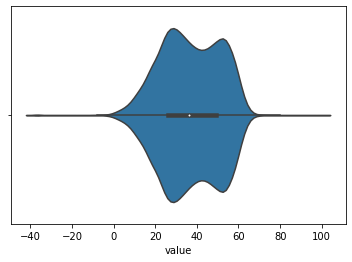

In [557]:
sns.violinplot(x=combined['value'], hue=combined['loc'].values, split=True, data=combined)

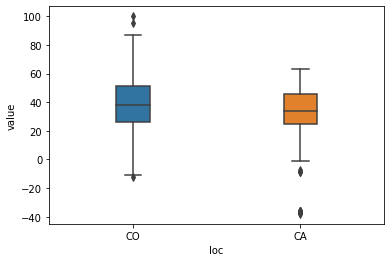

In [559]:
sns.boxplot(x = combined['loc'], y = combined['value'], width=0.2)

## APR 1 

In [561]:
dana_apr1 = dana_snotel[(dana_snotel['DATE TIME'].dt.day == 1) & (dana_snotel['DATE TIME'].dt.month == 4)]

In [562]:
co_apr1 = co_snotel[(co_snotel.Date.dt.day == 1) & (co_snotel.Date.dt.month == 4)]

In [565]:
dana_apr1 = dana_apr1.assign(location = 'CA')
co_apr1 = co_apr1.assign(location = "CO")

In [572]:
combined = pd.concat([dana_apr1[['location', 'VALUE']].rename({"VALUE": "WTEQ"}, axis=1), co_apr1[['location', 'WTEQ']]])
melted_apr1 = pd.melt(combined, id_vars='location', value_vars=['WTEQ'])

Text(0.5, 1.0, 'Apr 1 SWE')

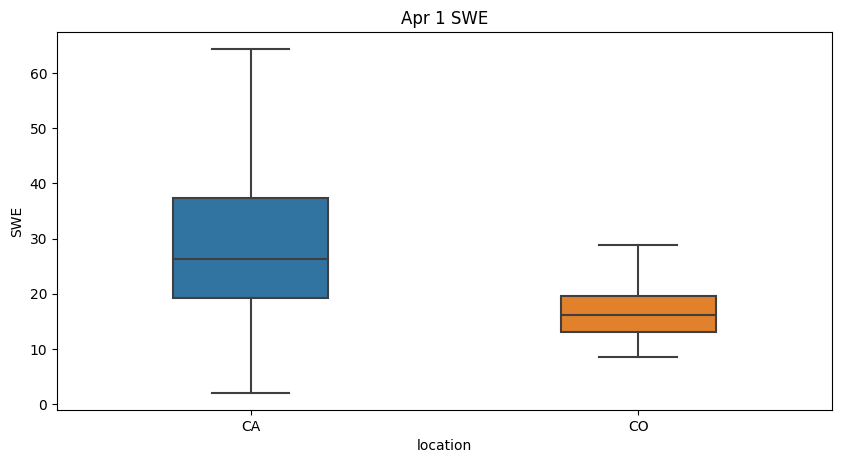

In [583]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
sns.boxplot(x = 'location', y = 'value', data=melted_apr1, width=0.4)
plt.ylabel("SWE")
plt.title("Apr 1 SWE")